# 📊 Data Audit & Quality Analysis for ArSL Hand Gesture Dataset

Before starting preprocessing or training, we perform a **Data Audit** to check dataset quality, find issues early, and detect inconsistencies.

---

## Purpose of the Audit
- Ensure the dataset is clean and consistent  
- Detect issues before preprocessing or training  
- Understand image variability and quality  
- Choose correct preprocessing steps  
- Avoid failures in hand detection, cropping, resizing, or model training

---

## What the Audit Does

### **1. Dataset Structure Check**
- Verify class folders  
- Ensure each class has images  
- Confirm all images can be read  (and if not, put them into `_reject` folder)
- Ensure that the data is balanced

### **2. Per-Image Statistics**
- Dimensions (width, height, channels)  
- Brightness levels  
- Aspect ratio

### **3. Detect Problematic Images**
- Blurry or motion-blurred images
- low contrast images  
- Too dark or too bright samples  
- Very small or very large images  

### **4. Visual Inspection**
Random samples per class to review:
- Hand clarity  
- Background clutter  
- Lighting  
- Camera distance  
- Noise 

---

## Issues the Audit Helps Identify

### **Hand Detection Issues**
- Very dark or bright images  
- Low contrast  
- Hand too small or too large  
- Motion blur  
- Strong or uneven lighting  

### **Edge Extraction Issues**
- Weak edges  
- Low finger detail  

### **Resizing & Augmentation Risks**
- Distortion from unusual aspect ratios  
- Rotations or flips that change gesture meaning  

---

## Audit Outputs
- Automatically detected issues  
- Saved in `data_audit_report.csv`  
- List of risky images  
- Visual previews for manual inspection  

---

## Summary
The Data Audit is a critical first step. It helps us understand the dataset, detect problems early, and build a solid foundation for all future preprocessing and model training steps.

# Import Libraries

In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# creates a progress bar
from tqdm import tqdm 
"""
# It shows you how much of the loop has been completed and how much is left very useful when processing many images
looks like:

40%|████      | 4/10 [00:01<00:02,  2.30it/s]
"""
import random
from skimage import filters
import math

# Load Dataset

In [2]:
BASE_DIR = os.getcwd() # Get the Current Working Directory -- r"\ArSL_HandGestureNet\notebooks"
DATA_DIR = Path(BASE_DIR) / "../data/structured/train_structured" # full path of the folder
# This folder will be used to store images that are invalid or rejected
REJECT_DIR = DATA_DIR / "_reject"
REJECT_DIR.mkdir(exist_ok=True) # creates a folder named _reject inside train_structured
# store class names and their images
dataset = {}
for class_dir in DATA_DIR.iterdir(): # DATA_DIR.iterdir() -> loops through everything inside train_structured
    if class_dir.is_dir() and class_dir.name not in "_reject": # check if the item is a directory and not in _reject folder
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png")) # Get all (.jpg && .png) images and Combine them into one list.
        dataset[class_dir.name] = images # Store them inside dataset
"""
dataset[] =
{
  "ALIF": [...list of image paths...],
  "BAA": [...],
}
"""

len(dataset.keys())

28

Returns the number of classes inside the dataset (excluding _reject)

### visualize dataset distribution

In [3]:
df = pd.DataFrame([
    {"class": k, "count": len(v)}
    for k, v in dataset.items()
])
df

class  count
0    ALIF    155
1     AYN    163
2     BAA    155
3     DAD    190
4    DELL    161
5    DHAA    164
6   DHELL    168
7     FAA    164
8   GHAYN    165
9      HA    163
10    HAA    160
11   JEEM    160
12   KAAF    168
13   KHAA    160
14   LAAM    163
15   MEEM    163
16   NOON    163
17   QAAF    164
18    RAA    172
19    SAD    188
20   SEEN    174
21  SHEEN    181
22     TA    159
23    TAA    173
24    THA    161
25    WAW    165
26     YA    163
27    ZAY    166

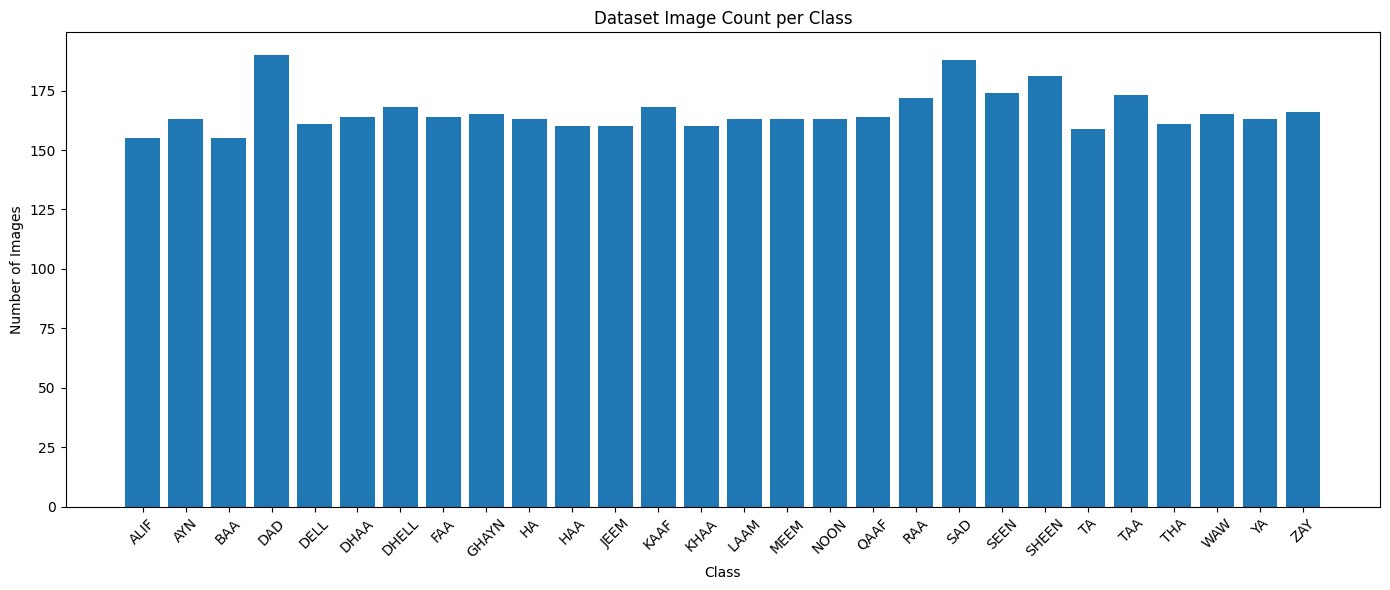

In [4]:
plt.figure(figsize=(14, 6))
plt.bar(df["class"], df["count"])
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Image Count per Class")
plt.tight_layout()
plt.show()

After visualizing the number of images per class, we found that the dataset is **well-balanced**.  
All classes contain approximately **155–190 images**, with only slight variations.  
These small differences do **not** constitute a real class imbalance and **should not negatively affect model training**.

# Collect Stats + Detect Corrupted Images

In [ ]:
stats = []
PROJECT_ROOT = Path().resolve().parent   # folder: ArSL_HandGestureNet
"""
the output of `tqdm(dataset.items())` is still the same as `dataset.items()`
So what does it return exactly? tqdm iterator that yields (class_name, images) pairs exactly like dataset.items()
    - class_name → the key ("ALIF", "BAA", ... )
    - images → the list of image paths inside that class
Nothing changes in the returned values
The only difference `tqdm` adds a progress bar on screen.
    >>> Processing classes:  40%|████      | 4/10 [00:01<00:02,  2.30it/s]
"""
for class_name, images in tqdm(dataset.items()):
    for img_path in images: 
        relative_path = img_path.relative_to(PROJECT_ROOT)
        img = cv2.imread(str(img_path))
        # If the image is invalid --> move it to _reject folder
        if img is None:
            shutil.move(str(img_path), REJECT_DIR / img_path.name)
            continue
        # extract the image dimensions
        # h = height
        # w = width
        # c = number of channels (3 = RGB)
        h, w, c = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
        edges = filters.sobel(gray)# but why grayscale? Because brightness and edge strength calculations work best in 1 channel
        stats.append({
            "class": class_name,
            "path": str(relative_path),
            "height": h,
            "width": w,
            "channels": c,
            "brightness": gray.mean(), # Average Grayscale intensity. (Higher value -> brighter image)
            "edge_strength": filters.sobel(gray).mean(), # Compute average edge strength using the Sobel filter
            "aspect_ratio": w / h, # helpful to see if images are square or stretched
            "variance": gray.var(), # compute variance that will be helpful to detect low contrast 
            "edge_density": (edges > 0.1).sum() / edges.size,  # % of image with edges
            "color_variance": img.reshape(-1, 3).var(axis=0).mean(),  # Color diversity
        })

df_stats = pd.DataFrame(stats)
df_stats.head(10)

100%|██████████| 28/28 [01:22<00:00,  2.96s/it]


class                                               path  height  width  \
0  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
1  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
2  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
3  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
4  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
5  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
6  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
7  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
8  ALIF  notebooks\..\data\structured\train_structured\...     416    416   
9  ALIF  notebooks\..\data\structured\train_structured\...     416    416   

   channels  brightness  edge_strength  aspect_ratio     variance  \
0         3  160.150691       0.027497           1.0  1903.976449   
1         3  165.057617       0.027818           1.0  1783.909327   
2         3  129.216907       0.028779           1.0  2304.257425   
3         3  132.453558       0.031307           1.0  1868.059430   
4         3  143.105330       0.050901           1.0  2367.782475   
5         3  143.611282       0.045240           1.0  2421.739593   
6         3  150.356301       0.046405           1.0  2260.381579   
7         3  145.661716       0.038932           1.0  3852.089949   
8         3  176.023830       0.023066           1.0  2533.984327   
9         3  128.116217       0.030593           1.0  2848.993948   

   edge_density  color_variance  
0      0.049175     1980.291886  
1      0.047337     1853.213337  
2      0.056161     2337.241593  
3      0.070359     1911.785550  
4      0.148854     2453.349247  
5      0.106873     2486.207692  
6      0.117153     2354.734026  
7      0.109034     3906.304911  
8      0.036745     2673.619015  
9      0.063482     2974.963900

All images in the dataset have exactly the same shape —> 416×416 pixels with 3 color channels. There is no variation in height, width, or number of channels. This means the dataset is fully consistent and uniform, so **no resizing or channel correction** is needed.

# Detect Expected Issues Automatically

## 1️- Image Quality Issues

| Issue             | How to Prove                                                       |
|------------------|-------------------------------------------------------------------|
| Blurry / Low-detail | Compute `edge_strength` for each image; identify low values (e.g., below 25th percentile) |
| Low contrast      | Compute image intensity variance; low values indicate low contrast |
---
## 2- Background Issues

| Issue                     | How to Prove                                              |
|---------------------------|----------------------------------------------------------|
| Background noise          | Visually inspect random samples                          |
| Cluttered backgrounds     | Compute `edge density` for full image; clutter increases edge density outside hand |
| Similar colors to hand/clothes | Low `color_variance` (<25th percentile) indicates possible confusion between hand and clothes/background|

---

# 1️- Image Quality Issues

> ### A. Identify blurry / low-quality images
How? - Compute `edge_strength` for each image; identify low values (e.g., below 25th percentile)

### Edge Strength Analysis
#### Edge Strength Statistics

In [6]:
summary = df_stats['edge_strength'].describe()
summary['skew'] = df_stats['edge_strength'].skew()
summary['kurtosis'] = df_stats['edge_strength'].kurt()
print(summary)

count       4651.000000
mean           0.031263
std            0.013445
min            0.003347
25%            0.021794
50%            0.029412
75%            0.038804
max            0.118072
skew           0.992820
kurtosis       2.150352
Name: edge_strength, dtype: float64


#### Edge Strength Distribution

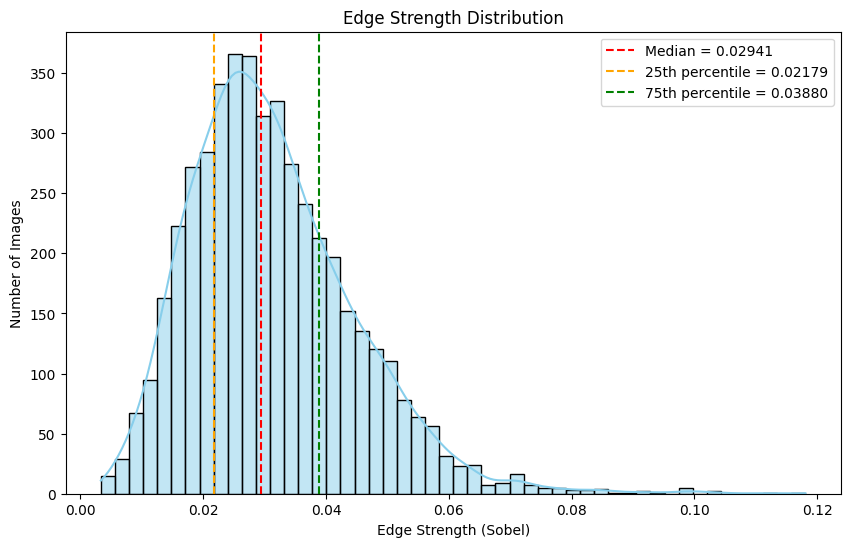

In [7]:
plt.figure(figsize=(10,6))

# Histogram + KDE
sns.histplot(df_stats['edge_strength'], bins=50, kde=True, color='skyblue')
plt.axvline(df_stats['edge_strength'].median(), color='red', linestyle='--', label=f"Median = {df_stats['edge_strength'].median():.5f}")
plt.axvline(df_stats['edge_strength'].quantile(0.25), color='orange', linestyle='--', label=f"25th percentile = {df_stats['edge_strength'].quantile(0.25):.5f}")
plt.axvline(df_stats['edge_strength'].quantile(0.75), color='green', linestyle='--', label=f"75th percentile = {df_stats['edge_strength'].quantile(0.75):.5f}")

plt.title("Edge Strength Distribution")
plt.xlabel("Edge Strength (Sobel)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


### Edge Strength Analysis - Summary

- **Distribution:** Right-skewed (Mean 0.03126 > Median 0.02941; Skew = 0.9928) means that most images have weak edges, few have strong edges
- **Kurtosis:** 2.15 →  slightly flatter than normal (3 -> Normal distribution: kurtosis = 3), no extreme outliers
- **Std Dev:** 0.01345 → small spread, edges mostly around mean
- **Percentiles:**
  - 25th: 0.02179 → very weak edges, low-quality images
  - 50th: 0.02941 → median
  - 75th: 0.03880 → stronger edges, high-detail images

**Key Insights:**
- Most images: weak to medium edges (0.02–0.04)
- Top 25%: sharp, high-detail images
- Bottom 25%: potential low-quality/blurry images
- Slight right-skew → consider when normalizing or thresholding

#### Show Number of low-quality images

In [8]:
EDGE_THRESHOLD = df_stats['edge_strength'].quantile(0.25)
df_stats['is_blurry'] = df_stats['edge_strength'] < EDGE_THRESHOLD
print("Number of  low-quality images:", df_stats['is_blurry'].sum())

Number of  low-quality images: 1163


#### Show example blurry / weak-edge images

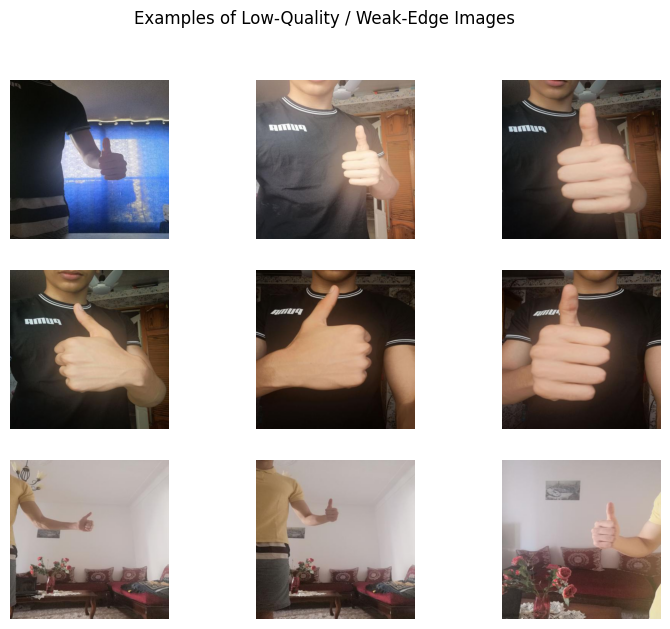

In [9]:
blurry_images = df_stats[df_stats['is_blurry']]['path'].tolist()[:9] 

plt.figure(figsize=(9,7))
for i, img_path in enumerate(blurry_images):
    img_path_full = PROJECT_ROOT / img_path  
    img = cv2.imread(str(img_path_full))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Examples of Low-Quality / Weak-Edge Images")
plt.show()

### Issues:
- Motion blur
- Overexposure / Underexposure
- Poor focus
- Subject too far from camera

> ## B. Detect low Contrast
Compute image **intensity variance**

In [10]:
CONTRAST_THRESHOLD = df_stats['variance'].quantile(0.25)   # Bottom 25%
BRIGHTNESS_MIN = df_stats['brightness'].quantile(0.10)     # Too dark
BRIGHTNESS_MAX = df_stats['brightness'].quantile(0.90)     # Too bright

df_stats['is_too_dark'] = df_stats['brightness'] < BRIGHTNESS_MIN
df_stats['is_too_bright'] = df_stats['brightness'] > BRIGHTNESS_MAX
df_stats['is_low_contrast'] = df_stats['variance'] < CONTRAST_THRESHOLD

print(f"Low Contrast: {df_stats['is_low_contrast'].sum()}")
print(f"Too Dark: {df_stats['is_too_dark'].sum()}")
print(f"Too Bright: {df_stats['is_too_bright'].sum()}")

Low Contrast: 1163
Too Dark: 465
Too Bright: 465


#### Actual Results:
- **Blurry images (low edge strength) from the previous step:** 1163 images
- **Low Contrast (low variance):** 1163 images
- **Too Dark:** 465 images
- **Too Bright:** 465 images

---

#### Question: Are these the SAME images or DIFFERENT images?

Let me clarify the **overlap** between these issues:

---

### Scenario Analysis:

#### Option 1: Complete Overlap
```
All 1163 blurry images = All 1163 low contrast images
```

**This means:**
- Every blurry image ALSO has low contrast
- Among these 1163 images:
  - 465 are too dark
  - 465 are too bright
  - 233 have normal brightness but still blurry + low contrast

**Why this makes sense:**
- Blurry images often lack sharp edges → low variance → low contrast
- Dark/bright images also tend to be blurry

- but this was wrong we will know why
---

#### Option 2: Partial Overlap
```
Some images are blurry BUT NOT low contrast
Some images are low contrast BUT NOT blurry
```

**To check this**


In [11]:
# Check overlap
blurry_and_low_contrast = df_stats[df_stats['is_blurry'] & df_stats['is_low_contrast']]
print(f"Both blurry AND low contrast: {len(blurry_and_low_contrast)}")

# Only blurry
only_blurry = df_stats[df_stats['is_blurry'] & ~df_stats['is_low_contrast']]
print(f"Only blurry (not low contrast): {len(only_blurry)}")

# Only low contrast
only_low_contrast = df_stats[~df_stats['is_blurry'] & df_stats['is_low_contrast']]
print(f"Only low contrast (not blurry): {len(only_low_contrast)}")

Both blurry AND low contrast: 454
Only blurry (not low contrast): 709
Only low contrast (not blurry): 709


### Visual Representation (Venn Diagram):
```
        ┌─────────────────┐       ┌─────────────────┐
        │     Blurry      │       │  Low Contrast   │
        │                 │       │                 │
        │      709        │       │      709        │
        │   (Only Blur)   │       │ (Only Low       │
        │                 │       │  Contrast)      │
        │         ┌───────┴───────┴───────┐         │
        │         │                       │         │
        │         │         454           │         │
        │         │  (Both Issues)        │         │
        │         │                       │         │
        └─────────┴───────────────────────┴─────────┘
```

---

### Total Counts:

| Category | Count | Calculation |
|----------|-------|-------------|
| **Total Blurry** | 1163 | 709 (only) + 454 (both) |
| **Total Low Contrast** | 1163 | 709 (only) + 454 (both) |
| **Both Issues** | 454 | Overlap |
| **Any Image Issue** | 1872 | 709 + 709 + 454 |

---

### Key Insights:

#### **Three Distinct Groups:**

##### Group A: Only Blurry (709 images)
- **Has:** Weak edges, motion blur, out of focus
- **Doesn't have:** Low contrast issue

##### Group B: Only Low Contrast (709 images)  
- **Has:** Low variance, flat appearance
- **Doesn't have:** Blur issue

##### Group C: Both Issues (454 images)
- **Has:** Weak edges + low variance
- **Worst quality group**

---

### What About Dark/Bright Images?

earlier numbers:
- **Too Dark:** 465 images
- **Too Bright:** 465 images

These 930 images (465 + 465) are **distributed across** the three groups above.
**To check this**

In [12]:
# Check where dark images are
dark_and_blurry = df_stats[df_stats['is_too_dark'] & df_stats['is_blurry']].shape[0]
dark_and_low_contrast = df_stats[df_stats['is_too_dark'] & df_stats['is_low_contrast']].shape[0]
dark_both = df_stats[df_stats['is_too_dark'] & df_stats['is_blurry'] & df_stats['is_low_contrast']].shape[0]

print(f"Dark + Blurry: {dark_and_blurry}")
print(f"Dark + Low Contrast: {dark_and_low_contrast}")
print(f"Dark + Both: {dark_both}")

# Same for bright
bright_and_blurry = df_stats[df_stats['is_too_bright'] & df_stats['is_blurry']].shape[0]
bright_and_low_contrast = df_stats[df_stats['is_too_bright'] & df_stats['is_low_contrast']].shape[0]
bright_both = df_stats[df_stats['is_too_bright'] & df_stats['is_blurry'] & df_stats['is_low_contrast']].shape[0]

print(f"Bright + Blurry: {bright_and_blurry}")
print(f"Bright + Low Contrast: {bright_and_low_contrast}")
print(f"Bright + Both: {bright_both}")

Dark + Blurry: 114
Dark + Low Contrast: 125
Dark + Both: 50
Bright + Blurry: 230
Bright + Low Contrast: 288
Bright + Both: 157


### Simple Summary - Image Quality Issues
#### **Complete Quality Distribution:**
```
Total Dataset: 4651 images

┌─────────────────────────────────────────────────┐
│ Perfect Quality (no issues)                     │
│ 4651 - 1872 = 2779 images (59.7%)               │
└─────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────┐
│ Has Issues: 1872 images (40.3%)                 │
│                                                 │
│  ├─ Only Blurry: 709                            │
│  │   ├─ Dark: 64                                │
│  │   ├─ Bright: 73                              │
│  │   └─ Normal lighting: 572                    │
│  │                                              │
│  ├─ Only Low Contrast: 709                      │
│  │   ├─ Dark: 75                                │
│  │   ├─ Bright: 131                             │
│  │   └─ Normal lighting: 503                    │
│  │                                              │
│  ├─ Both (Blur + Low Contrast): 454             │
│  │   ├─ Dark: 50                                │
│  │   ├─ Bright: 157     (WORST GROUP)           │
│  │   └─ Normal lighting: 247                    │
│  │                                              │
│  └─ Only Lighting Issues: 380                   │
│      ├─ Only Dark (good quality): 276           │
│      └─ Only Bright (good quality): 104         │
└─────────────────────────────────────────────────┘
```

### Key Takeaways:

#### **Good:**
1. **59.7% of your dataset is perfect quality** (2779 images)
2. **Dark images are mostly recoverable** (59% just need brightness adjustment)
3. **380 images** only have lighting issues (can be fixed with preprocessing)

#### **Bad:**
1. **Bright images are problem** - 77.6% have quality issues beyond brightness
2. **157 bright images** have triple problems (blur + contrast + brightness)
3. **40.3% of dataset** needs attention
---

# 2- Background Issues

## Issue 1: Background Noise

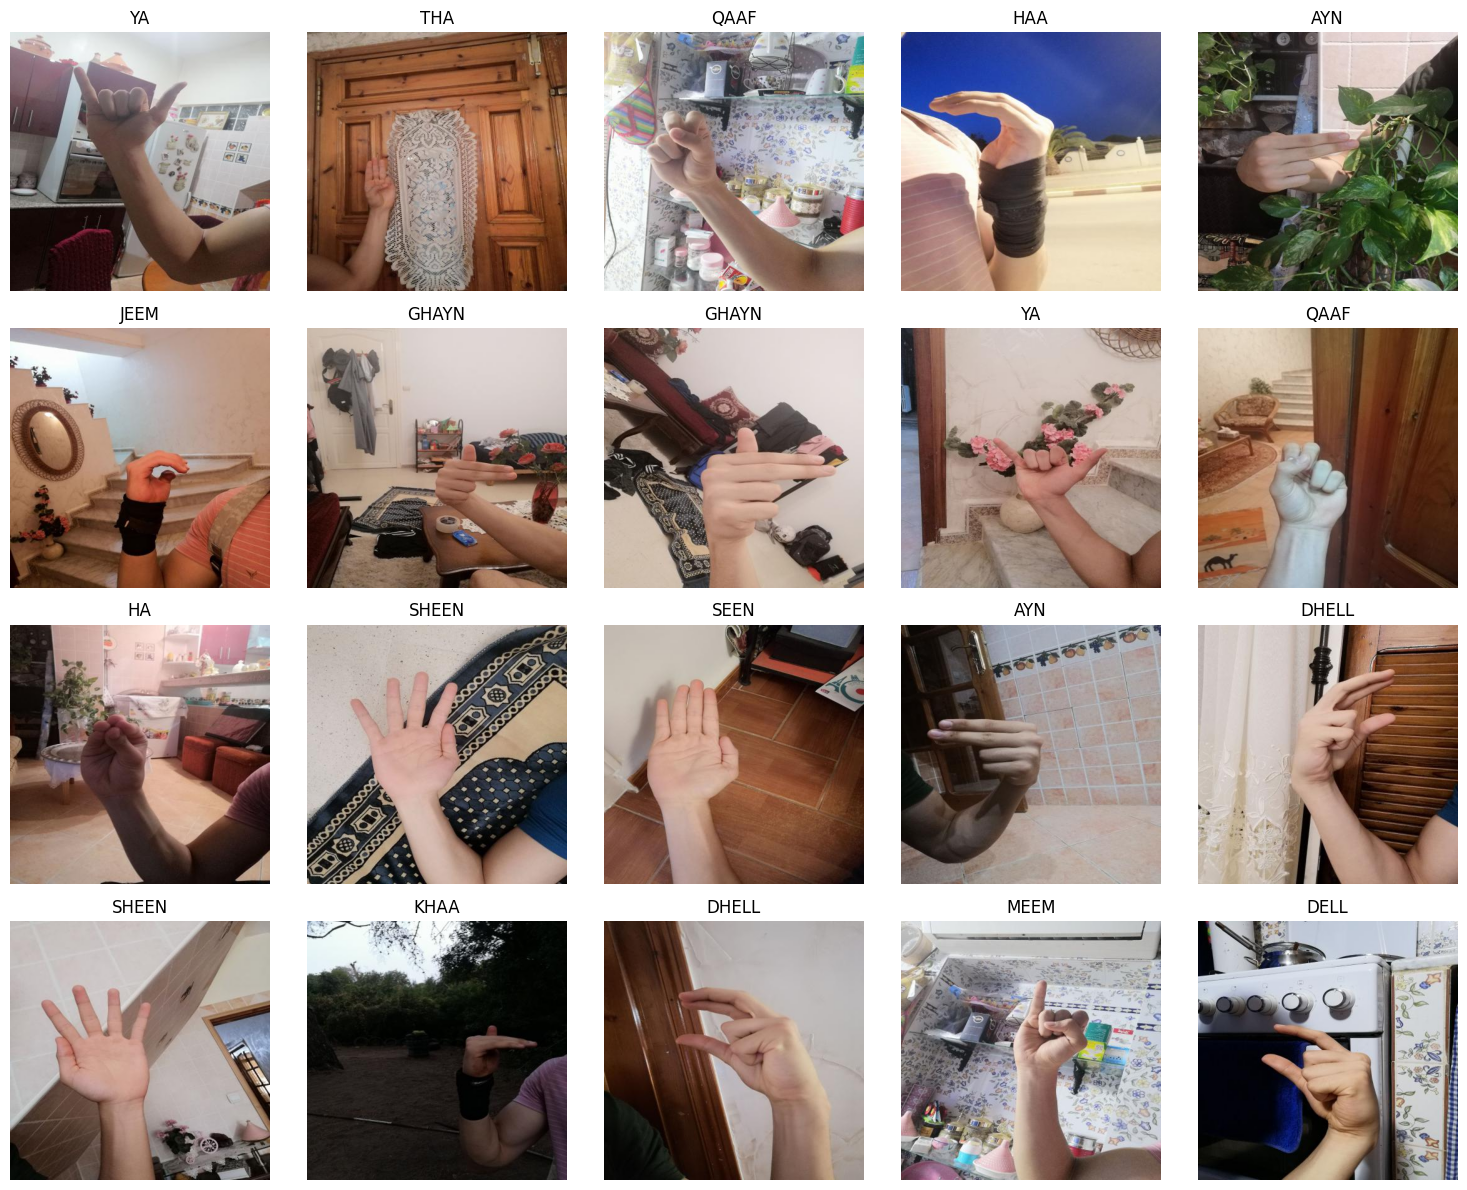

In [13]:
def show_random_samples(df, n=20):
    samples = df.sample(n)
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path_full = PROJECT_ROOT / row['path']  
        img = cv2.imread(str(img_path_full))   
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"{row['class']}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
show_random_samples(df_stats)

### Issue 2: Cluttered Backgrounds

In [14]:
cluttered = df_stats[df_stats['edge_density'] > df_stats['edge_density'].quantile(0.75)]
print(f"Cluttered backgrounds: {len(cluttered)}")

Cluttered backgrounds: 1163


### Issue 3: Similar Colors (Hand/Clothes vs Background)

In [ ]:
low_color = df_stats[df_stats['color_variance'] < df_stats['color_variance'].quantile(0.25)]
print(f"Low color separation: {len(low_color)}")

Low color separation: 1163


### Visualize worst cases

In [16]:
def visualize_worst_images(df, column, n=5, ascending=True, title=""):
    """
    Display one row of images
    
    Args:
        df: DataFrame
        column: Column name to sort by
        n: Number of images (default 5)
        ascending: True for smallest, False for largest
        title: Plot title
    """
    # Get worst images
    if ascending:
        worst = df.nsmallest(n, column)
    else:
        worst = df.nlargest(n, column)
    
    # Create one row
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    
    for i, (idx, row) in enumerate(worst.iterrows()):
        # Load image
        img_path = PROJECT_ROOT / row['path']
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(
            f"{row['class']}\n{column}: {row[column]:.4f}",
            fontsize=9
        )
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

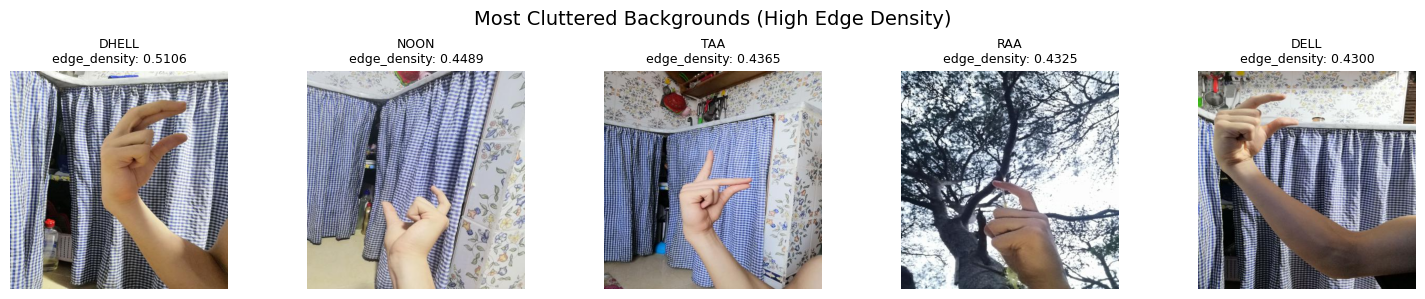

In [17]:
# Most cluttered backgrounds (highest edge density)
visualize_worst_images(
    df_stats, 
    'edge_density', 
    n=5, 
    ascending=False,  # False = largest values
    title="Most Cluttered Backgrounds (High Edge Density)"
)

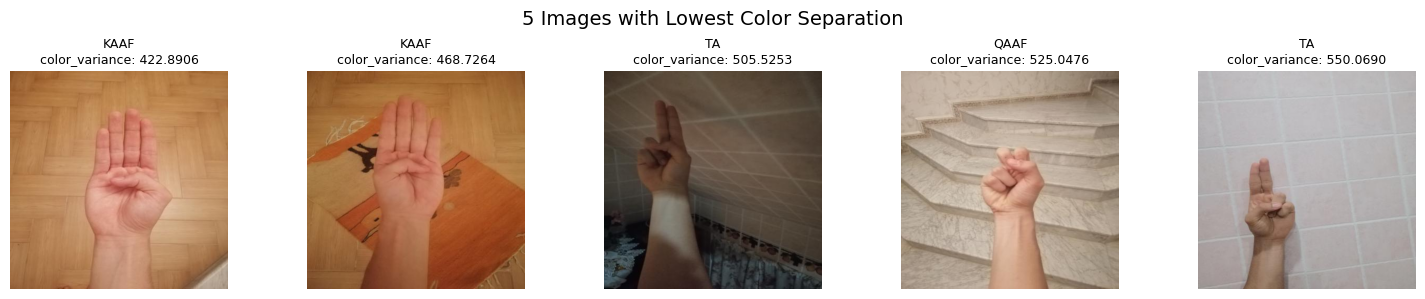

In [ ]:
# Lowest color separation (5 worst)
visualize_worst_images(
    df_stats, 
    'color_variance', 
    n=5, 
    ascending=True,
    title="5 Images with Lowest Color Separation"
)

In [19]:
# Check overlap - images with BOTH issues
both_issues = df_stats[
    (df_stats['edge_density'] > df_stats['edge_density'].quantile(0.75)) &
    (df_stats['color_variance'] < df_stats['color_variance'].quantile(0.25))
]
print(f"Images with both cluttered background AND low color separation: {len(both_issues)}")

Images with both cluttered background AND low color separation: 181


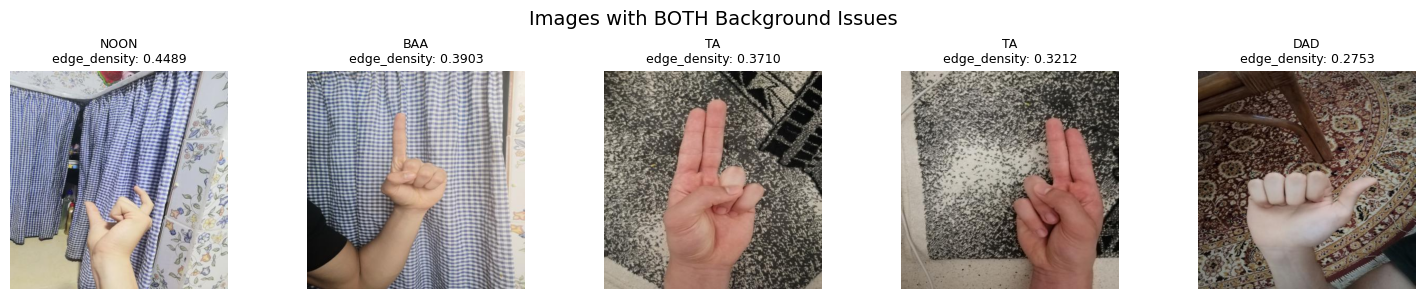

In [20]:
visualize_worst_images(
    both_issues, 
    'edge_density', 
    n=5, 
    ascending=False,
    title="Images with BOTH Background Issues"
)

### Background Issues - Simple Summary

---
###  Problems:

#### 1. Background Noise
- Messy/distracting backgrounds
    - Furniture, objects, or people appearing in the frame
    - Posters, decorations, or windows

Impact:
- Unrelated items draw attention away from the hand and may cause the model to learn incorrect features

#### 2. Cluttered Backgrounds
- Too many edges/details in background
- Complex patterns (carpets, fabrics, tiles)
- High edge density confuses model
- Background competes with hand for attention

Impact:
- High edge density in the background competes with the hand, making it harder for the model to focus on the gesture

#### 3. Similar Colors (Low Color Separation)
- skin color matches background
- Low contrast between hand and background
- Hand boundaries not visible

Impact:
- The hand boundaries become unclear, reducing the model’s ability to distinguish finger shapes and gesture contours

#### 4. Combined Issues (Worst Case)
Impact:
- Cluttered background + similar colors together
- Hand is both invisible AND surrounded by noise
- Impossible for model to detect hand

---

## Show all Problems

In [25]:
clutter_threshold = df_stats["edge_density"].quantile(0.75)
color_threshold = df_stats["color_variance"].quantile(0.25)

problems = df_stats[
    (df_stats["is_blurry"]) |
    (df_stats["is_too_dark"]) |
    (df_stats["is_too_bright"]) |
    (df_stats["is_low_contrast"]) |
    (df_stats["edge_density"] > clutter_threshold) |
    (df_stats["color_variance"] < color_threshold)
]

In [28]:
problems

class                                               path  height  width  \
0     ALIF  notebooks\..\data\structured\train_structured\...     416    416   
1     ALIF  notebooks\..\data\structured\train_structured\...     416    416   
2     ALIF  notebooks\..\data\structured\train_structured\...     416    416   
3     ALIF  notebooks\..\data\structured\train_structured\...     416    416   
4     ALIF  notebooks\..\data\structured\train_structured\...     416    416   
...    ...                                                ...     ...    ...   
4646   ZAY  notebooks\..\data\structured\train_structured\...     416    416   
4647   ZAY  notebooks\..\data\structured\train_structured\...     416    416   
4648   ZAY  notebooks\..\data\structured\train_structured\...     416    416   
4649   ZAY  notebooks\..\data\structured\train_structured\...     416    416   
4650   ZAY  notebooks\..\data\structured\train_structured\...     416    416   

      channels  brightness  edge_strength  aspect_ratio     variance  \
0            3  160.150691       0.027497           1.0  1903.976449   
1            3  165.057617       0.027818           1.0  1783.909327   
2            3  129.216907       0.028779           1.0  2304.257425   
3            3  132.453558       0.031307           1.0  1868.059430   
4            3  143.105330       0.050901           1.0  2367.782475   
...        ...         ...            ...           ...          ...   
4646         3  115.824294       0.043743           1.0  3165.176661   
4647         3  126.865662       0.023918           1.0  2081.156671   
4648         3   94.358491       0.049423           1.0  2407.623998   
4649         3  109.089266       0.049997           1.0  4628.220166   
4650         3  146.039363       0.018259           1.0  2518.499005   

      edge_density  color_variance  is_blurry  is_too_dark  is_too_bright  \
0         0.049175     1980.291886      False        False           True   
1         0.047337     1853.213337      False        False           True   
2         0.056161     2337.241593      False        False          False   
3         0.070359     1911.785550      False        False          False   
4         0.148854     2453.349247      False        False          False   
...            ...             ...        ...          ...            ...   
4646      0.130605     3391.134715      False        False          False   
4647      0.035803     2419.818048      False        False          False   
4648      0.158735     2673.311343      False         True          False   
4649      0.168419     4911.462903      False        False          False   
4650      0.039415     2658.515925       True        False          False   

      is_low_contrast  
0                True  
1                True  
2                True  
3                True  
4                True  
...               ...  
4646            False  
4647             True  
4648             True  
4649            False  
4650            False  

[3139 rows x 15 columns]

In [29]:
problems.describe()

height   width  channels   brightness  edge_strength  aspect_ratio  \
count  3139.0  3139.0    3139.0  3139.000000    3139.000000        3139.0   
mean    416.0   416.0       3.0   125.869191       0.031800           1.0   
std       0.0     0.0       0.0    25.683043       0.015962           0.0   
min     416.0   416.0       3.0    19.361085       0.003347           1.0   
25%     416.0   416.0       3.0   109.469105       0.018859           1.0   
50%     416.0   416.0       3.0   128.202276       0.028345           1.0   
75%     416.0   416.0       3.0   145.123945       0.043459           1.0   
max     416.0   416.0       3.0   203.786526       0.118072           1.0   

          variance  edge_density  color_variance  
count  3139.000000   3139.000000     3139.000000  
mean   3019.879746      0.081767     3158.734348  
std    1198.582457      0.063314     1205.462160  
min     335.386513      0.000237      422.890628  
25%    2111.264049      0.033090     2250.715400  
50%    2914.564070      0.061304     3055.893416  
75%    3795.373237      0.120166     3969.517314  
max    8536.416629      0.510644     8715.569227

In [31]:
problems.to_csv("../reports/data_audit_report.csv", index=False)

- `count = 3,139` images have at least one issue (blurry, too dark, too bright, low contrast, cluttered, or low color variance)
- Percentage of dataset: 
$$
\frac{3139}{4651} ≈ 67%
$$
- 67% a large portion of the dataset contains problematic images

## Data Audit – Image & Background Issues Summary

### Dataset Overview
- **Total images:** 4,651  
- **Perfect quality images:** 2,779 (~60%)  
- **Images with issues:** 3,139 (~67%)  

---

### Key Image Quality Issues
- **Blurry:** 709  
- **Low contrast:** 709  
- **Both blur + low contrast:** 454 (worst-quality group)  
- **Lighting issues only (too dark/bright):** 465 → correctable  

---

### Key Background Issues
- **Background noise:** most images  
- **Cluttered backgrounds:** 1,163  
- **Low color separation:** 1,163  
- **Both clutter + low color separation:** 181 → critical group  

---

### Overall Insights
- **High prevalence of issues:** ~67% of the dataset has at least one problem affecting model performance
- **Critical images:** **454** with both blur + low contrast, and **181** with combined background issues
- **Actionable takeaway:** Correctable lighting issues can be addressed with preprocessing, while priority should be given to worst-quality images and those with critical background problems to ensure robust model training.